In [1]:
!pip install pennylane
!pip install networkx matplotlib
import pennylane as qml          # Core quantum simulation library
from pennylane import numpy as np  # PennyLane's NumPy wrapper (autograd-compatible)

import networkx as nx            # For creating and visualizing graphs
import matplotlib.pyplot as plt  # For plotting graphs and results
import seaborn as sns

import time
import random
from tqdm import tqdm

import pandas as pd
import json
import os

import scipy
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim


zsh:1: command not found: pip
zsh:1: command not found: pip


ModuleNotFoundError: No module named 'pennylane'

In [ ]:
import networkx as nx

Create Graph

In [ ]:
vertices=np.array([0,1,2,3,4])
edges=np.array([[0,1],[1,2],[2,3],[3,4],[4,0]])

Graph: Ladder (12 nodes)
Vertices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Edges: [(0, 1), (0, 6), (1, 2), (1, 7), (2, 3), (2, 8), (3, 4), (3, 9), (4, 5), (4, 10), (5, 11), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11)]


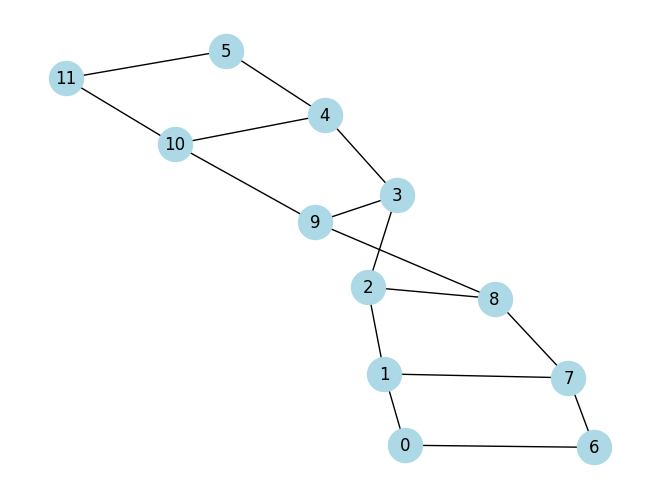

In [ ]:
# G = nx.Graph()      # create empty graph
# G.add_nodes_from([0, 1, 2, 3, 4])
# G.add_edges_from([(0, 1), (1, 2), (2, 3),(3,4),(4,0)])

# G = nx.complete_bipartite_graph(3, 3)
# print("Graph: K3,3")
# print("Vertices:", list(G.nodes()))
# print("Edges:", list(G.edges()))

# G = nx.random_regular_graph(d=3, n=10, seed=42)
# print("Graph: Random 3-Regular (8 nodes, degree 3)")
# print("Vertices:", list(G.nodes()))
# print("Edges:", list(G.edges()))

# G = nx.complete_graph(6)
# print("Graph: K6")
# print("Vertices:", list(G.nodes()))
# print("Edges:", list(G.edges()))

# G = nx.grid_2d_graph(3, 4)
# # Relabel to single indices (0–11)
# G = nx.convert_node_labels_to_integers(G)
# print("Graph: 3x4 Grid (12 nodes)")
# print("Vertices:", list(G.nodes()))
# print("Edges:", list(G.edges()))

G = nx.ladder_graph(6)  # total 12 nodes
print("Graph: Ladder (12 nodes)")
print("Vertices:", list(G.nodes()))
print("Edges:", list(G.edges()))

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600)
plt.show()

Defining device and wires

In [ ]:
qubits=len(G.nodes())
dev=qml.device('default.qubit',wires=qubits,shots=1000)

Problem Hamiltonian

In [ ]:
coeff_p = [1 for (i,j) in G.edges()]  # coefficients (can be -1 if negative of objective)
obs_p = [qml.PauliZ(i) @ qml.PauliZ(j) for (i,j) in G.edges()]  # observables
H_p = qml.Hamiltonian(coeff_p, obs_p)  # final Hamiltonian


Initial Hamiltonian

In [ ]:
coeff_i=[-1 for i in G.nodes()]
obs_i=[qml.PauliX(i) for i in G.nodes()]
H_i=qml.Hamiltonian(coeff_i,obs_i)

Initial State

In [ ]:
def int_state():
  for i in range(qubits):
    qml.Hadamard(wires=i)

Time Scheduler

In [ ]:
T=30
def s(t):
  return (t/T)**2

Time Evolving Hamiltonian

In [ ]:
def H(t):
  return (1-s(t))*H_i + s(t)*H_p

Final Circuit

In [ ]:
M=200
h = 1
dt=T/M

In [ ]:
@qml.qnode(dev)
def circuit():
  #initial state
  int_state()

  for k in range(M):
    #single qubit
    for i in range(qubits):
      qml.RX(-2*(1-s(k*dt))*dt/h,wires=i)

    #coupled qubit
    for (i,j) in G.edges():
      qml.CNOT(wires=[i,j])
      qml.RZ(2*(s(k*dt))*dt/h,wires=j)
      qml.CNOT(wires=[i,j])

  return qml.expval(H_p)

In [ ]:
@qml.qnode(dev)
def get_sample():
    int_state()
    for k in range(M):
        for i in range(qubits):
            qml.RX(-2*(1-s(k*dt))*dt/h, wires=i)
        for (i,j) in G.edges():
            qml.CNOT(wires=[i,j])
            qml.RZ(2*(s(k*dt))*dt/h, wires=j)
            qml.CNOT(wires=[i,j])
    return qml.sample(wires=range(qubits))

In [ ]:
exp=circuit()
sample=get_sample()
print(exp)
print(sample)
print(0.5*(len(G.edges())-exp))

-15.570000000000004
[[1 0 1 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 [0 1 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 1 0 1]]
15.785000000000002


Best bitstring: [1 0 1 0 1 0 0 1 0 1 0 1]
Max-Cut value: 16.0


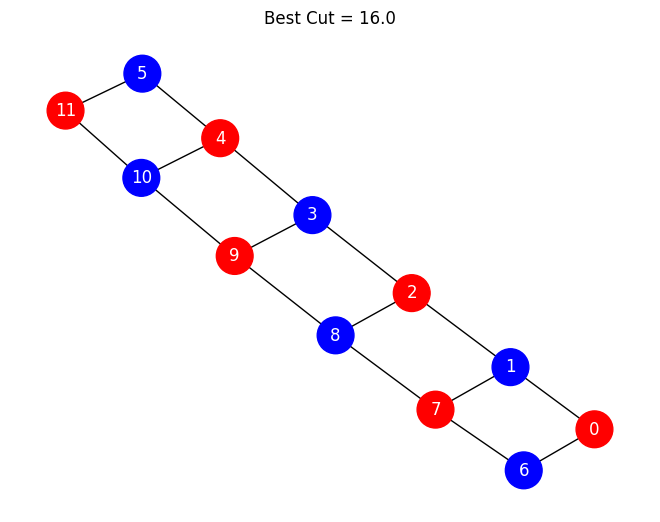

In [ ]:
import numpy as np

def bitstring_to_spin(bits):
    """Convert 0→+1, 1→−1"""
    return 1 - 2 * bits

def maxcut_value(spins, edges):
    """Compute cut value for one spin configuration"""
    val = 0
    for (i, j) in edges:
        val += 0.5 * (1 - spins[i] * spins[j])
    return val

def find_best_cut(samples, G):
    best_val = -1
    best_sample = None
    for bits in samples:
        spins = bitstring_to_spin(bits)
        val = maxcut_value(spins, G.edges())
        if val > best_val:
            best_val = val
            best_sample = bits
    return best_sample, best_val

best_sample, best_val = find_best_cut(sample, G)
print("Best bitstring:", best_sample)
print("Max-Cut value:", best_val)

spins = 1 - 2 * best_sample
color_map = ["red" if s == -1 else "blue" for s in spins]

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=700, font_color='white')
plt.title(f"Best Cut = {best_val}")
plt.show()
